# Разведочный анализ данных

## Описание

Основная задача проекта – выявить ключевые темы обсуждений у 18 активных чатов и каналов выпускных сообществ Яндекс Практикума, определить, какие из них наиболее интересны аудитории, и на основе этого формировать информативные дайджесты для выпускников.

**Контекст**

- необходимо провести первичный анализ сообщений,

**Что нужно сделать?**

1. кто пишет часто
2. в какое время чаще всего пишут пользователи
3. сколько пишут сообщений сколько
4. анализ времени → пики активности, дни недели.
5. подумать, что можно еще посчитать полезного

**Результат:**

- код .py, .ipynb
- csv/xlsx файл со статистикой

## Библиотеки

In [1]:
import logging
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ast
from wordcloud import WordCloud
from collections import Counter

# Настройка параметров matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

# Настройка стиля seaborn
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

## Загрузка датасетов

In [2]:
df = pd.read_csv('..\def_Klyusnik_A\output\processed_messages.csv')
df_1 = pd.read_csv('..\def_Klyusnik_A\output\processed_messages_1.csv')

print('Загрузка df:', df.shape, 'загрузка df_1:', df_1.shape)

Загрузка df: (13, 18) загрузка df_1: (1007, 36)


## Df Первый датасет представленный заказчиком

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             13 non-null     object 
 1   type             13 non-null     object 
 2   id_first         13 non-null     int64  
 3   id               13 non-null     int64  
 4   type.1           13 non-null     object 
 5   date             13 non-null     object 
 6   date_unixtime    13 non-null     int64  
 7   edited           13 non-null     object 
 8   edited_unixtime  13 non-null     int64  
 9   from             13 non-null     object 
 10  from_id          13 non-null     object 
 11  text             13 non-null     object 
 12  text_entities    13 non-null     object 
 13  reactions        13 non-null     object 
 14  photo            9 non-null      object 
 15  photo_file_size  9 non-null      float64
 16  width            9 non-null      float64
 17  height           9

In [4]:
df.head(5)

,name,type,id_first,id,type.1,date,date_unixtime,edited,edited_unixtime,from,from_id,text,text_entities,reactions,photo,photo_file_size,width,height
0,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,856,message,2025-02-01T14:06:16,1738407976,2025-02-01T14:07:41,1738408061,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': '💥'}, {'type': 'bold...","[{'type': 'bold', 'text': '💥'}, {'type': 'bold...","[{'type': 'emoji', 'count': 6, 'emoji': '👍'}, ...",NaN,NaN,NaN,NaN
1,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,857,message,2025-02-02T14:07:55,1738494475,2025-02-03T13:05:36,1738577136,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': '💭 Переговорный клуб...","[{'type': 'bold', 'text': '💭 Переговорный клуб...","[{'type': 'emoji', 'count': 8, 'emoji': '🔥'}, ...",photos/photo_368@02-02-2025_14-07-55.jpg,130046.0,1280.0,1280.0
2,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,858,message,2025-02-03T14:04:43,1738580683,2025-02-03T14:10:35,1738581035,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': 'У Практикума новый ...","[{'type': 'bold', 'text': 'У Практикума новый ...","[{'type': 'emoji', 'count': 11, 'emoji': '🔥'},...",NaN,NaN,NaN,NaN
3,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,859,message,2025-02-04T19:02:42,1738684962,2025-02-04T19:08:41,1738685321,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': 'Прямой эфир с Олей ...","[{'type': 'bold', 'text': 'Прямой эфир с Олей ...","[{'type': 'emoji', 'count': 8, 'emoji': '👍'}, ...",photos/photo_369@04-02-2025_19-02-42.jpg,108894.0,1280.0,1280.0
4,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,860,message,2025-02-07T14:07:55,1738926475,2025-02-07T14:09:14,1738926554,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': 'Питчинг: как презен...","[{'type': 'bold', 'text': 'Питчинг: как презен...","[{'type': 'emoji', 'count': 11, 'emoji': '🔥'},...",NaN,NaN,NaN,NaN


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_first,13.0,1.586397e+09,0.000000,1.586397e+09,1.586397e+09,1.586397e+09,1.586397e+09,1.586397e+09
id,13.0,8.620000e+02,3.894440,8.560000e+02,8.590000e+02,8.620000e+02,8.650000e+02,8.680000e+02
date_unixtime,13.0,1.739319e+09,708246.072971,1.738408e+09,1.738685e+09,1.739186e+09,1.739877e+09,1.740560e+09
edited_unixtime,13.0,1.739326e+09,700785.169874,1.738408e+09,1.738685e+09,1.739186e+09,1.739877e+09,1.740561e+09
photo_file_size,9.0,1.302191e+05,17649.220255,9.600600e+04,1.257000e+05,1.328580e+05,1.452550e+05,1.460310e+05
width,9.0,1.257778e+03,66.666667,1.080000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03
height,9.0,1.252000e+03,65.084560,1.080000e+03,1.260000e+03,1.280000e+03,1.280000e+03,1.280000e+03


In [6]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

name - 0%
type - 0%
id_first - 0%
id - 0%
type.1 - 0%
date - 0%
date_unixtime - 0%
edited - 0%
edited_unixtime - 0%
from - 0%
from_id - 0%
text - 0%
text_entities - 0%
reactions - 0%
photo - 31%
photo_file_size - 31%
width - 31%
height - 31%


**Общее количество записей:** 13

**Количество колонок:** 18

**Пропуски:**

Колонки photo, photo_file_size, width, и height имеют пропуски (9 ненулевых значений из 13).
Остальные колонки не содержат пропусков.

**Типы данных:**

- 4 колонки имеют тип int64.
- 3 колонки имеют тип float64.
- 11 колонок имеют тип object (строковые данные).

**Статистические характеристики:**

- Колонка id_first имеет постоянное значение (1.586397e+09).
- Колонка id варьируется от 856 до 868.
- Временные метки (date_unixtime и edited_unixtime) имеют схожие значения, с небольшими колебаниями.
- Для колонок photo_file_size, width и height доступны статистические данные только для 9 записей, что указывает на наличие пропусков.

### name

In [7]:
df['name'].unique()

array(['MANAGEMENT ALUMNI PRACTICUM'], dtype=object)

**Анализ одного чата**

### type

In [8]:
df['type'].unique()

array(['private_channel'], dtype=object)

**Только приватный канал менеджмента**

### id_first

In [9]:
df['id_first'].unique() 

array([1586396652], dtype=int64)

**Данный id - сам канал**

### id

In [10]:
df['id'].unique() 

array([856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868],
      dtype=int64)

**Каждое сообщение идет с присвоением своего id**

### type.1

In [11]:

df['type.1'].unique() 

array(['message'], dtype=object)

**Маркировка типа сообщения. В других датасетах оно может отличаться**

## date

In [12]:
df['date'] = pd.to_datetime(df['date'])

df['date_only'] = df['date'].dt.date

# Извлечение дня недели
df['day_of_week'] = df['date'].dt.day_name()  # или df['date'].dt.weekday для числового представления (0=понедельник, 6=воскресенье)

# Извлечение времени
df['time_only'] = df['date'].dt.time

In [13]:
df['date_only'] 

0     2025-02-01
1     2025-02-02
2     2025-02-03
3     2025-02-04
4     2025-02-07
5     2025-02-08
6     2025-02-10
7     2025-02-13
8     2025-02-17
9     2025-02-18
10    2025-02-20
11    2025-02-21
12    2025-02-26
Name: date_only, dtype: object

**Всго 12 дней февраля**

In [14]:
df['day_of_week']

0      Saturday
1        Sunday
2        Monday
3       Tuesday
4        Friday
5      Saturday
6        Monday
7      Thursday
8        Monday
9       Tuesday
10     Thursday
11       Friday
12    Wednesday
Name: day_of_week, dtype: object

In [15]:
df['time_only']

0     14:06:16
1     14:07:55
2     14:04:43
3     19:02:42
4     14:07:55
5     13:59:58
6     14:05:55
7     13:59:58
8     14:03:18
9     14:04:38
10    13:59:58
11    15:08:07
12    11:59:58
Name: time_only, dtype: object

**Общая активность начиналась с 11:00 и до 19:00**

### date_unixtime

**date_unixtime - метки в формате Unix (количество секунд с 1 января 1970 года)**

### edited

In [16]:
df['edited'] = pd.to_datetime(df['edited'])

df['edited_only'] = df['edited'].dt.date

# Извлечение дня недели
df['day_of_week_edited'] = df['edited'].dt.day_name()  # или df['edited'].dt.weekday для числового представления (0=понедельник, 6=воскресенье)

# Извлечение времени
df['time_only_edited'] = df['edited'].dt.time 

In [17]:
df['edited_only']

0     2025-02-01
1     2025-02-03
2     2025-02-03
3     2025-02-04
4     2025-02-07
5     2025-02-08
6     2025-02-10
7     2025-02-13
8     2025-02-17
9     2025-02-18
10    2025-02-20
11    2025-02-21
12    2025-02-26
Name: edited_only, dtype: object

**Аномалий нет, даты совпадают**

In [18]:
df['day_of_week_edited']

0      Saturday
1        Monday
2        Monday
3       Tuesday
4        Friday
5      Saturday
6        Monday
7      Thursday
8        Monday
9       Tuesday
10     Thursday
11       Friday
12    Wednesday
Name: day_of_week_edited, dtype: object

In [19]:
df['time_only_edited']

0     14:07:41
1     13:05:36
2     14:10:35
3     19:08:41
4     14:09:14
5     14:03:31
6     14:06:50
7     14:43:19
8     14:04:47
9     14:15:10
10    14:00:24
11    15:44:43
12    12:01:46
Name: time_only_edited, dtype: object

In [20]:
df['time_difference'] = df['edited'] - df['date']
df['minutes_difference'] = df['time_difference'].dt.total_seconds() / 60
df['minutes_difference']


0        1.416667
1     1377.683333
2        5.866667
3        5.983333
4        1.316667
5        3.550000
6        0.916667
7       43.350000
8        1.483333
9       10.533333
10       0.433333
11      36.600000
12       1.800000
Name: minutes_difference, dtype: float64

**Первая аномалия кто-то писал сообщение целые сутки**

### edited_unixtime

**edited_unixtime - метки в формате Unix (количество секунд с 1 января 1970 года)**

### from

In [21]:
df['from'].unique()

array(['MANAGEMENT ALUMNI PRACTICUM'], dtype=object)

**Так же в нашем слуае сылки видут только на один чат**

### from_id

In [22]:
df.from_id.unique()

array(['channel1586396652'], dtype=object)

**from_id дублирует id first**

### text

In [23]:
# Преобразование строки в список словарей и сохранение результата
df['text'] = df['text'].apply(ast.literal_eval)

# Извлечение значения 'text' из списка словарей
df['text_clean'] = df['text'].apply(lambda x: x[0]['text'] if x else None)

#### Облако слов

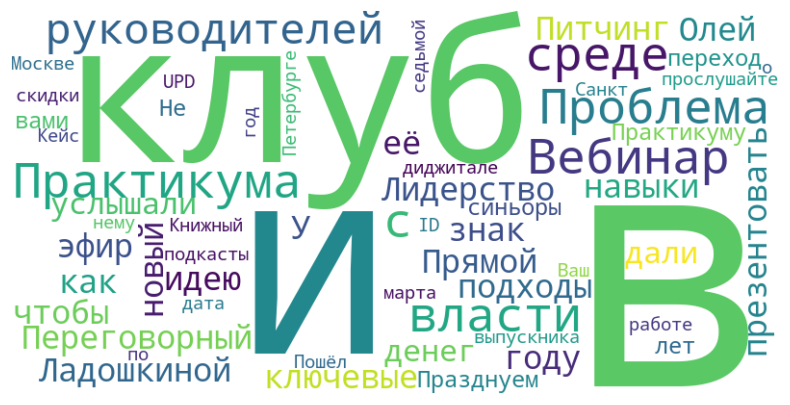

In [24]:
text = ' '.join(df['text_clean'])

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключение осей
plt.show()


**Мы получили токины, играющие подавляющую роль**

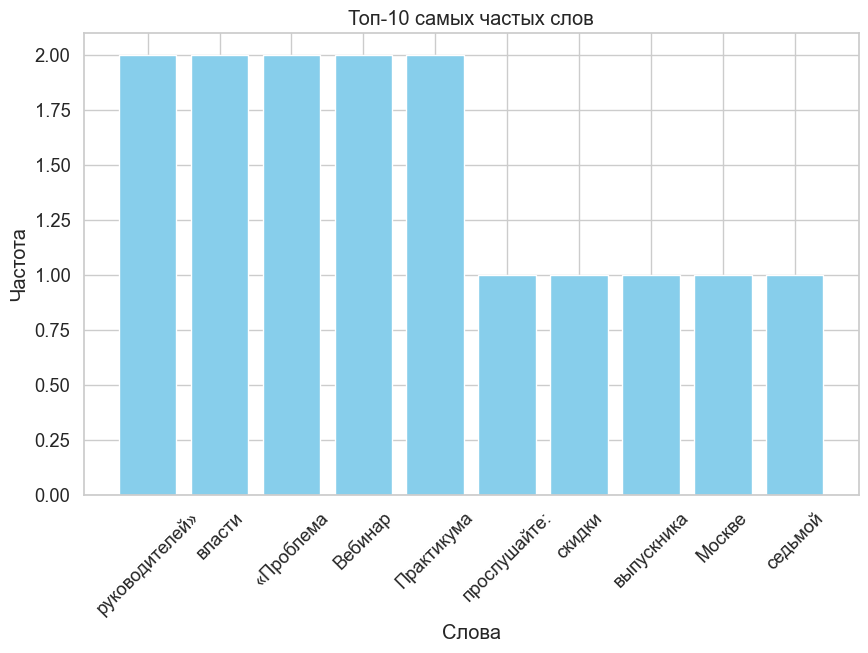

In [25]:
# Разделение текстов на слова и подсчёт частот
if df['text_clean'].empty or df['text_clean'].isna().all():
    print("Нет текстовых данных для анализа")
else:
    # Очистка и фильтрация данных
    clean_texts = df['text_clean'].dropna().astype(str)
    
    if len(clean_texts) == 0:
        print("После очистки не осталось текстовых данных")
    else:
        # Объединение текстов, разделение на слова и фильтрация
        all_words = [word for text in clean_texts 
                    for word in text.split() 
                    if len(word) > 5]  # Фильтр по длине слова
        
        if not all_words:
            print("Нет слов длиной более 5 букв")
        else:
            # Подсчет частоты слов
            word_counts = Counter(all_words)

# Преобразование в DataFrame
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
word_counts_df = word_counts_df.sort_values('frequency', ascending=False)

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(word_counts_df['word'][:10], word_counts_df['frequency'][:10], color='skyblue')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.title('Топ-10 самых частых слов')
plt.xticks(rotation=45)
plt.show()

**Тригерные слова**

### text_entities

In [26]:
# Преобразование строки в список словарей и сохранение результата
df['text_entities'] = df['text_entities'].apply(ast.literal_eval)

# Извлечение значения 'text' из списка словарей
df['text_entities_clean'] = df['text_entities'].apply(lambda x: x[0]['text'] if x else None)

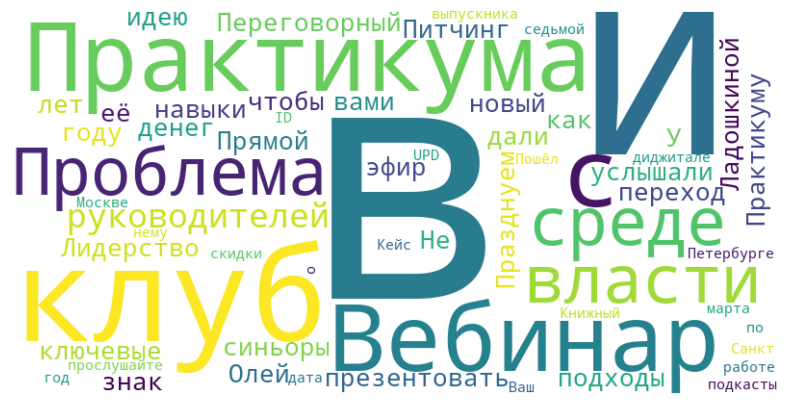

In [27]:
text = ' '.join(df['text_entities_clean'])

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключение осей
plt.show()

**Дальше можно не продолжать, сущность полностью повторяет сам text**

### reactions

In [28]:
df['reactions'] = df['reactions'].apply(ast.literal_eval)

# Извлечение данных
df['reactions_clean'] = df['reactions'].apply(
    lambda x: {item['emoji']: item['count'] for item in x} if x else None
)

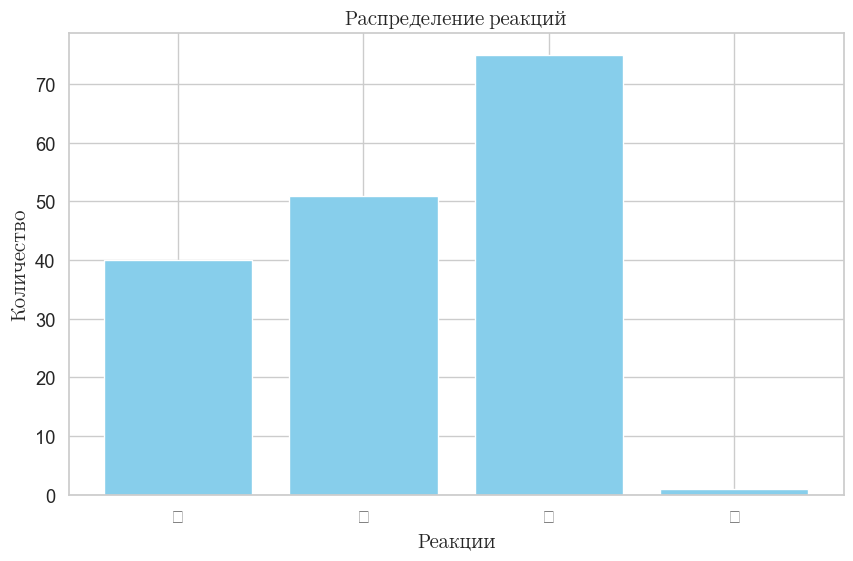

In [29]:
all_reactions = {}
for reactions in df['reactions_clean'].dropna():
    for emoji, count in reactions.items():
        if emoji in all_reactions:
            all_reactions[emoji] += count
        else:
            all_reactions[emoji] = count

# Преобразование в DataFrame
reactions_df = pd.DataFrame(all_reactions.items(), columns=['emoji', 'count'])

import matplotlib.font_manager as fm

font_path = '..\def_Klyusnik_A\input\Symbola.ttf'
font_prop = fm.FontProperties(fname=font_path)

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(reactions_df['emoji'], reactions_df['count'], color='skyblue')
plt.xlabel('Реакции', fontproperties=font_prop)
plt.ylabel('Количество', fontproperties=font_prop)
plt.title('Распределение реакций', fontproperties=font_prop)
plt.show()

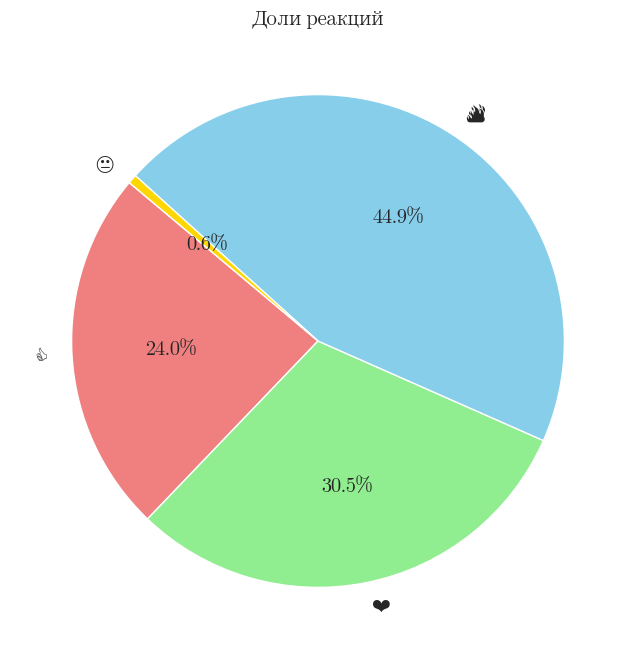

In [30]:
plt.figure(figsize=(8, 8))
plt.pie(reactions_df['count'], labels=reactions_df['emoji'], 
autopct='%1.1f%%', startangle=140, 
colors=['lightcoral', 'lightgreen', 'skyblue', 'gold'],
textprops={'fontproperties': font_prop})
plt.title('Доли реакций', fontproperties=font_prop)
plt.show()

**Реакции под постами теплые и активные**

### photo, photo_file_size, width, height

**Данные колонки не сильно интересны, так как расскрывают фото, стиль, размер**

### Кто пишет часто?

In [31]:
# Подсчет количества сообщений от каждого отправителя
message_counts = df['from'].value_counts()

# Преобразование в DataFrame для удобства
message_counts_df = message_counts.reset_index()
message_counts_df.columns = ['sender', 'message_count']

# Сортировка по количеству сообщений
message_counts_df = message_counts_df.sort_values(by='message_count', ascending=False)

# Вывод результатов
print(message_counts_df)

# Если хотите вывести только топ-10 отправителей
print(message_counts_df.head(10))

                        sender  message_count
0  MANAGEMENT ALUMNI PRACTICUM             13
                        sender  message_count
0  MANAGEMENT ALUMNI PRACTICUM             13


**Менеджмент**

### В какое время чаще всего пишут пользователи

In [32]:
# Подсчет количества сообщений по времени
time_counts = df['time_only'].value_counts()

# Преобразование в DataFrame для удобства
time_counts_df = time_counts.reset_index()
time_counts_df.columns = ['time', 'message_count']

# Сортировка по количеству сообщений
time_counts_df = time_counts_df.sort_values(by='message_count', ascending=False)

# Если хотите вывести только топ-10 временных значений
print(time_counts_df.head(10))

       time  message_count
0  13:59:58              3
1  14:07:55              2
2  14:06:16              1
3  14:04:43              1
4  19:02:42              1
5  14:05:55              1
6  14:03:18              1
7  14:04:38              1
8  15:08:07              1
9  11:59:58              1


## Aнализ времени → пики активности, дни недели.

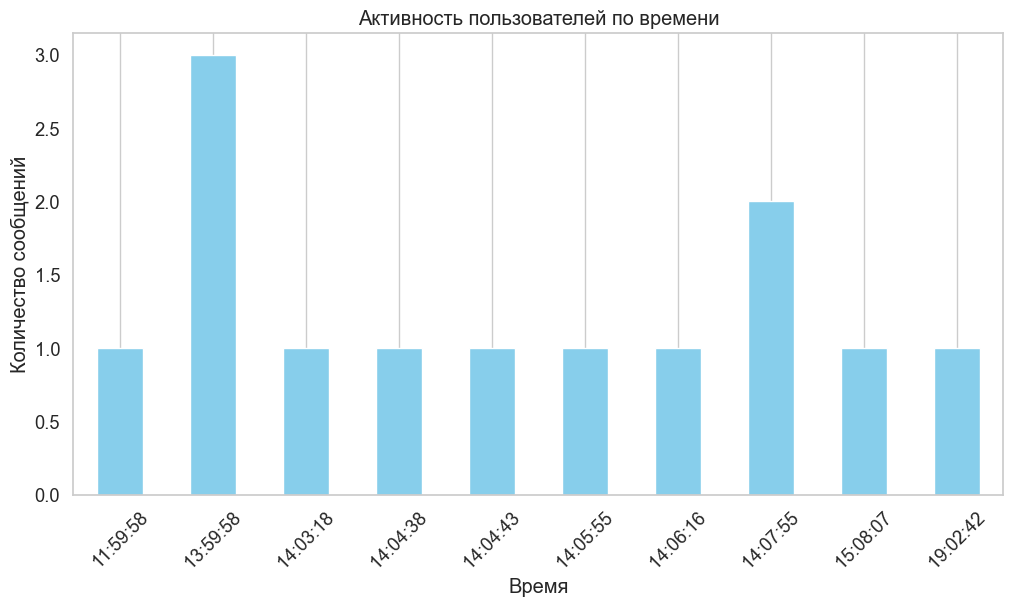

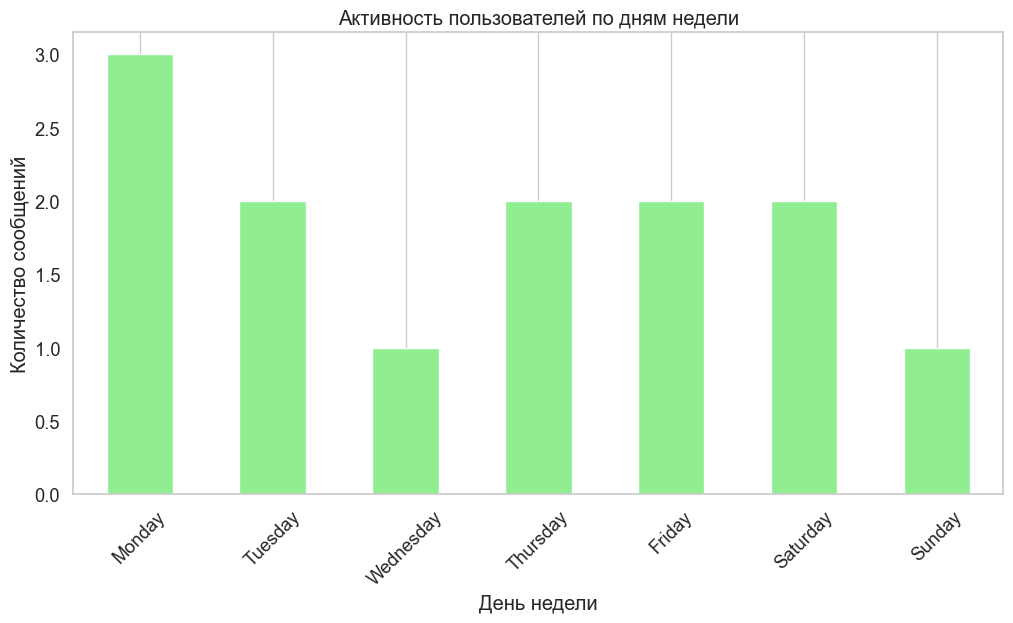

In [33]:
# 1. Анализ по времени
time_counts = df['time_only'].value_counts().sort_index()

# Визуализация активности по времени
plt.figure(figsize=(12, 6))
time_counts.plot(kind='bar', color='skyblue')
plt.title('Активность пользователей по времени')
plt.xlabel('Время')
plt.ylabel('Количество сообщений')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 2. Анализ по дням недели
day_counts = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Визуализация активности по дням недели
plt.figure(figsize=(12, 6))
day_counts.plot(kind='bar', color='lightgreen')
plt.title('Активность пользователей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество сообщений')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**В среднем в понедельник после обеда и пошли работать**

### 1. Общее количество сообщений


In [34]:
# 1. Общее количество сообщений
total_messages = len(df)
print(f"Общее количество сообщений: {total_messages}")

Общее количество сообщений: 13


### 2. Активность по пользователям


In [35]:
user_activity = df['from'].value_counts()
print("Активность по пользователям:")
print(user_activity)

Активность по пользователям:
from
MANAGEMENT ALUMNI PRACTICUM    13
Name: count, dtype: int64


### 3. Среднее время между сообщениями


In [36]:
df = df.sort_values(by='date')  # Сортировка по времени
df['time_difference'] = df['date'].diff().dt.total_seconds() / 60  # Разница в минутах
average_time_between_messages = df['time_difference'].mean()
print(f"Среднее время между сообщениями: {average_time_between_messages:.2f} минут")

Среднее время между сообщениями: 2989.47 минут


### 4. Частота сообщений по дням


In [37]:
daily_activity = df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print("Частота сообщений по дням:")
print(daily_activity)

Частота сообщений по дням:
day_of_week
Monday       3
Tuesday      2
Wednesday    1
Thursday     2
Friday       2
Saturday     2
Sunday       1
Name: count, dtype: int64


### 5. Частота сообщений по часам


In [38]:
df['hour'] = df['date'].dt.hour
hourly_activity = df['hour'].value_counts().sort_index()
print("Частота сообщений по часам:")
print(hourly_activity)

Частота сообщений по часам:
hour
11    1
13    3
14    7
15    1
19    1
Name: count, dtype: int64


### 6. Топ-10 пользователей по количеству сообщений


In [39]:
top_users = user_activity.head(10)
print("Топ-10 пользователей по количеству сообщений:")
print(top_users)

Топ-10 пользователей по количеству сообщений:
from
MANAGEMENT ALUMNI PRACTICUM    13
Name: count, dtype: int64


In [40]:
# 7. Анализ длины сообщений
df['message_length'] = df['text_clean'].str.len()  # Длина сообщений
average_length = df['message_length'].mean()
print(f"Средняя длина сообщения: {average_length:.2f} символов")

Средняя длина сообщения: 39.85 символов


## Df_1 Второй датасет представленный заказчиком

In [41]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 1007 non-null   object 
 1   type                 1007 non-null   object 
 2   id_first             1007 non-null   int64  
 3   id                   1007 non-null   int64  
 4   type.1               1007 non-null   object 
 5   date                 1007 non-null   object 
 6   date_unixtime        1007 non-null   int64  
 7   actor                83 non-null     object 
 8   actor_id             83 non-null     object 
 9   action               83 non-null     object 
 10  inviter              81 non-null     object 
 11  text                 881 non-null    object 
 12  text_entities        1007 non-null   object 
 13  from                 924 non-null    object 
 14  from_id              924 non-null    object 
 15  reply_to_message_id  689 non-null    f

In [42]:
df_1.head(5)


,name,type,id_first,id,type.1,date,date_unixtime,actor,actor_id,action,...,mime_type,duration_seconds,width,height,forwarded_from,saved_from,photo,photo_file_size,via_bot,members
0,💬 Data Practicum Chat,private_supergroup,1379846874,266690,service,2025-02-01T22:40:19,1738438819,Елизавета,user200103497,join_group_by_link,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,💬 Data Practicum Chat,private_supergroup,1379846874,266691,service,2025-02-02T21:59:34,1738522774,Agamet Agametov,user217302209,join_group_by_link,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,💬 Data Practicum Chat,private_supergroup,1379846874,266693,message,2025-02-03T11:28:38,1738571318,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,💬 Data Practicum Chat,private_supergroup,1379846874,266694,message,2025-02-03T11:52:20,1738572740,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,💬 Data Practicum Chat,private_supergroup,1379846874,266695,message,2025-02-03T11:52:37,1738572757,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
id_first,1007.0,1.379847e+09,0.000000,1.379847e+09,1.379847e+09,1.379847e+09,1.379847e+09,1.379847e+09
id,1007.0,2.672655e+05,340.181234,2.666900e+05,2.669545e+05,2.672780e+05,2.675615e+05,2.678330e+05
date_unixtime,1007.0,1.739563e+09,744229.454320,1.738439e+09,1.738688e+09,1.739699e+09,1.740305e+09,1.740685e+09
reply_to_message_id,689.0,2.669298e+05,8356.218262,4.810400e+04,2.669090e+05,2.672890e+05,2.675780e+05,2.678310e+05
edited_unixtime,313.0,1.739558e+09,757364.825343,1.738573e+09,1.738688e+09,1.739702e+09,1.740381e+09,1.741865e+09
file_size,38.0,1.924576e+05,464917.315289,1.248400e+04,2.940950e+04,4.148600e+04,1.405078e+05,2.678208e+06
thumbnail_file_size,34.0,1.264703e+04,5499.742239,2.846000e+03,8.379000e+03,1.216700e+04,1.722300e+04,2.312000e+04
duration_seconds,16.0,3.625000e+00,2.247221,1.000000e+00,2.750000e+00,3.000000e+00,3.250000e+00,1.000000e+01
width,69.0,6.877826e+02,304.995510,1.660000e+02,5.120000e+02,5.120000e+02,9.330000e+02,1.280000e+03
height,69.0,6.475797e+02,350.741752,7.200000e+01,4.660000e+02,5.120000e+02,9.130000e+02,1.280000e+03


In [44]:
for col in df_1.columns:
    pct_missing = np.mean(df_1[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

name - 0%
type - 0%
id_first - 0%
id - 0%
type.1 - 0%
date - 0%
date_unixtime - 0%
actor - 92%
actor_id - 92%
action - 92%
inviter - 92%
text - 13%
text_entities - 0%
from - 8%
from_id - 8%
reply_to_message_id - 32%
edited - 69%
edited_unixtime - 69%
reactions - 72%
file - 96%
file_name - 96%
file_size - 96%
thumbnail - 97%
thumbnail_file_size - 97%
media_type - 96%
sticker_emoji - 97%
mime_type - 96%
duration_seconds - 98%
width - 93%
height - 93%
forwarded_from - 99%
saved_from - 99%
photo - 97%
photo_file_size - 97%
via_bot - 100%
members - 100%


**В DataFrame содержится 1007 строк и 36 столбцов, включая информацию о сообщениях, таких как отправитель, текст, время отправления и редактирования. Основные пропуски наблюдаются в столбцах actor, actor_id, action и inviter, где более 90% значений отсутствуют. Текст сообщения присутствует в 881 из 1007 записей**



**Удалим колонки в котороых больше 70% пропуски**

In [45]:
# Вычисление процента пропусков и удаление столбцов с более чем 70% пропусков
threshold = 0.7  # 70%
cols_to_drop = []

for col in df_1.columns:
    pct_missing = np.mean(df_1[col].isnull())
    if pct_missing > threshold:
        cols_to_drop.append(col)

# Удаление столбцов
df_1.drop(columns=cols_to_drop, inplace=True)

# Вывод оставшихся столбцов
print("Оставшиеся столбцы после удаления:")
print(df_1.columns)

Оставшиеся столбцы после удаления:
Index(['name', 'type', 'id_first', 'id', 'type.1', 'date', 'date_unixtime',
       'text', 'text_entities', 'from', 'from_id', 'reply_to_message_id',
       'edited', 'edited_unixtime'],
      dtype='object')


### name

In [46]:
df_1['name'].unique()

array(['💬 Data Practicum Chat'], dtype=object)

**Анализ одного чата**

### type

In [47]:
df_1['type'].unique()

array(['private_supergroup'], dtype=object)

**Это группа с группами, бодее насдстроенный чат**

### id_first

In [48]:
df_1['id_first'].unique() 

array([1379846874], dtype=int64)

**Данный id - сам канал**

### id

In [49]:
print('Уникальные записи', df_1['id'].unique())
print('Их количество', len(df_1['id'].unique()))

Уникальные записи [266690 266691 266693 ... 267831 267832 267833]
Их количество 1007


**Каждое сообщение идет с присвоением своего id**

### type.1

In [50]:
df_1['type.1'].unique() 

array(['service', 'message'], dtype=object)

**Маркировка типа сообщения. В других датасетах оно может отличаться**

## date

In [51]:
df_1['date'] = pd.to_datetime(df_1['date'])

df_1['date_only'] = df_1['date'].dt.date

# Извлечение дня недели
df_1['day_of_week'] = df_1['date'].dt.day_name()  # или df['date'].dt.weekday для числового представления (0=понедельник, 6=воскресенье)

# Извлечение времени
df_1['time_only'] = df_1['date'].dt.time
df_1['date_only'].unique() 

array([datetime.date(2025, 2, 1), datetime.date(2025, 2, 2),
       datetime.date(2025, 2, 3), datetime.date(2025, 2, 4),
       datetime.date(2025, 2, 5), datetime.date(2025, 2, 6),
       datetime.date(2025, 2, 7), datetime.date(2025, 2, 8),
       datetime.date(2025, 2, 9), datetime.date(2025, 2, 10),
       datetime.date(2025, 2, 11), datetime.date(2025, 2, 12),
       datetime.date(2025, 2, 13), datetime.date(2025, 2, 14),
       datetime.date(2025, 2, 15), datetime.date(2025, 2, 16),
       datetime.date(2025, 2, 17), datetime.date(2025, 2, 18),
       datetime.date(2025, 2, 19), datetime.date(2025, 2, 20),
       datetime.date(2025, 2, 21), datetime.date(2025, 2, 22),
       datetime.date(2025, 2, 23), datetime.date(2025, 2, 24),
       datetime.date(2025, 2, 25), datetime.date(2025, 2, 26),
       datetime.date(2025, 2, 27)], dtype=object)

**Теперь Месяц**

In [52]:
df_1['day_of_week'].unique() 

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

**Общение с пн-вс**

**Общая активность начиналась с 11:00 и до 23:00**

### date_unixtime


**date_unixtime - метки в формате Unix (количество секунд с 1 января 1970 года)**

### edited

In [54]:
df_1['edited'] = pd.to_datetime(df_1['edited'])

df_1['edited_only'] = df_1['edited'].dt.date

# Извлечение дня недели
df_1['day_of_week_edited'] = df_1['edited'].dt.day_name()  # или df_1['edited'].dt.weekday для числового представления (0=понедельник, 6=воскресенье)

# Извлечение времени
df_1['time_only_edited'] = df_1['edited'].dt.time 
df_1['edited_only'].unique()

array([NaT, datetime.date(2025, 2, 3), datetime.date(2025, 2, 4),
       datetime.date(2025, 2, 5), datetime.date(2025, 2, 6),
       datetime.date(2025, 2, 17), datetime.date(2025, 2, 7),
       datetime.date(2025, 2, 10), datetime.date(2025, 2, 8),
       datetime.date(2025, 2, 11), datetime.date(2025, 2, 12),
       datetime.date(2025, 2, 14), datetime.date(2025, 2, 16),
       datetime.date(2025, 2, 18), datetime.date(2025, 2, 19),
       datetime.date(2025, 2, 22), datetime.date(2025, 2, 20),
       datetime.date(2025, 2, 21), datetime.date(2025, 2, 23),
       datetime.date(2025, 2, 24), datetime.date(2025, 2, 25),
       datetime.date(2025, 2, 26), datetime.date(2025, 2, 27),
       datetime.date(2025, 3, 13)], dtype=object)

**Аномалий нет, даты совпадают**

In [55]:
df_1['day_of_week_edited'].unique()

array([nan, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday'], dtype=object)

In [57]:
df_1['time_difference'] = df_1['edited'] - df_1['date']
df_1['minutes_difference'] = df_1['time_difference'].dt.total_seconds() / 60
print(df_1['minutes_difference'].min(), df_1['minutes_difference'].max(), df_1['minutes_difference'].mean())

0.05 20384.05 209.48674121405753



**В среднем люди отвечают по 210 минут**


### edited_unixtime

**edited_unixtime - метки в формате Unix (количество секунд с 1 января 1970 года)**

### from

In [58]:
user_activity = df_1['from'].value_counts()

# Выводим пользователей с наибольшим количеством сообщений
print("Пользователи с наибольшим количеством сообщений:")
print(user_activity)

# Если хотите вывести только топ-10 пользователей
print("\nТоп-10 пользователей по количеству сообщений:")
print(user_activity.head(10))

Пользователи с наибольшим количеством сообщений:
from
Irina                  89
Andrey Novikov         79
Мариян Умагалова       78
Илья                   71
Sergey                 52
                       ..
Ирина                   1
Andrei Sukharevsky      1
Maksim                  1
RD58                    1
✏️Aleksandr Stavrov     1
Name: count, Length: 131, dtype: int64

Топ-10 пользователей по количеству сообщений:
from
Irina                            89
Andrey Novikov                   79
Мариян Умагалова                 78
Илья                             71
Sergey                           52
Arsen (არსენა) Хабибуллин        39
Ksenia                           34
Anna Glagoleva                   34
Ilya Plotnikov                   33
Катерина Ефремова [+2,5ч мск]    28
Name: count, dtype: int64


**Irina, Andrey Novikov самые активные**        

### from_id


In [65]:
len(df_1.from_id)

1007

**from_id дублирует id first**

### text

In [60]:
def safe_literal_eval(x):
    try:
        # Проверяем, является ли значение строкой и не является ли NaN
        if isinstance(x, str) and x.lower() != 'nan':
            return ast.literal_eval(x)
        return None
    except (ValueError, SyntaxError):
        return None

# Применяем функцию к столбцу
df_1['text'] = df_1['text'].apply(safe_literal_eval)

# Извлекаем текст из первого словаря в списке (если он существует)
df_1['text_clean'] = df_1['text'].apply(
    lambda x: x[0]['text'] if x and isinstance(x, list) and len(x) > 0 and isinstance(x[0], dict) and 'text' in x[0] else None
)

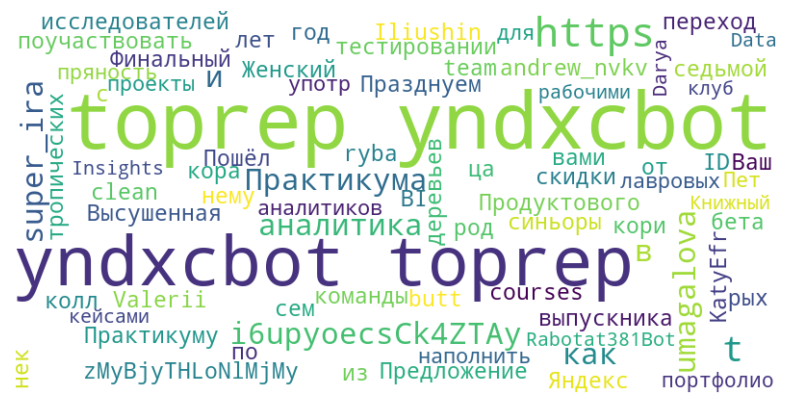

In [61]:
if len(df_1['text_clean']) == 0:
    print("Нет текстовых данных для создания облака слов")
else:
    # 3. Объединение текстов (только не-None значений)
    text = ' '.join([str(t) for t in df_1['text_clean'] if t is not None])

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключение осей
plt.show()

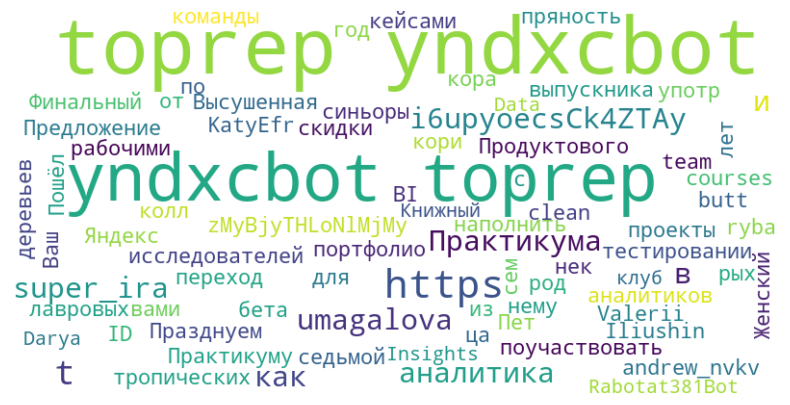

In [62]:
if len(df_1['text_clean']) == 0:
    print("Нет текстовых данных для создания облака слов")
else:
    # 3. Объединение текстов (только не-None значений)
    text = ' '.join([str(t) for t in df_1['text_clean'] if t is not None])

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключение осей
plt.show()


**Мы получили токины, играющие подавляющую роль**


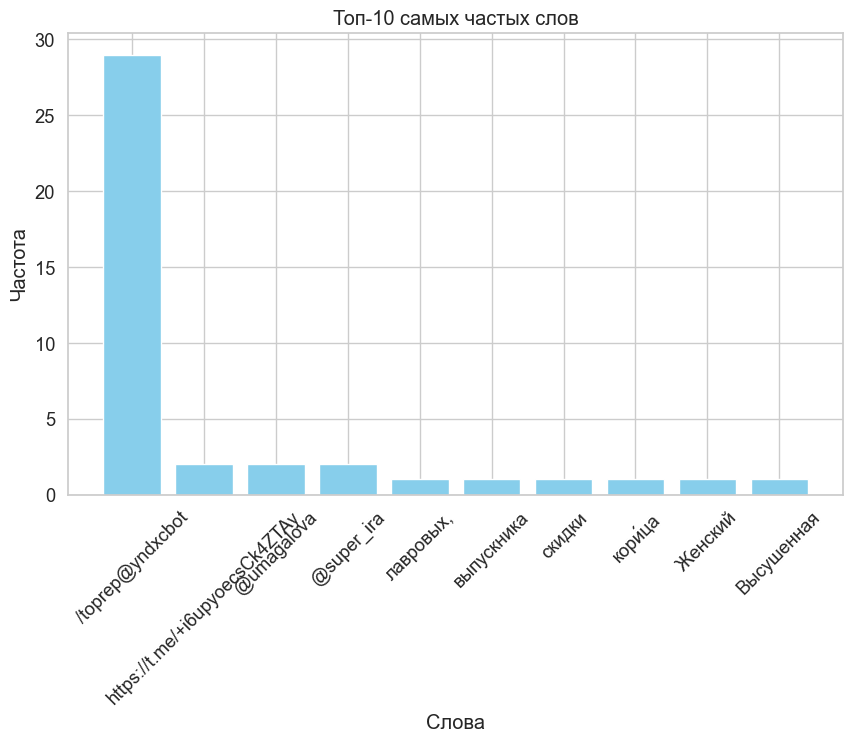

In [63]:
# Проверка наличия данных
if df_1['text_clean'].empty or df_1['text_clean'].isna().all():
    print("Нет текстовых данных для анализа")
else:
    # Очистка и фильтрация данных
    clean_texts = df_1['text_clean'].dropna().astype(str)
    
    if len(clean_texts) == 0:
        print("После очистки не осталось текстовых данных")
    else:
        # Объединение текстов, разделение на слова и фильтрация
        all_words = [word for text in clean_texts 
                    for word in text.split() 
                    if len(word) > 5]  # Фильтр по длине слова
        
        if not all_words:
            print("Нет слов длиной более 5 букв")
        else:
            # Подсчет частоты слов
            word_counts = Counter(all_words)
# word_counts = Counter(all_words)

# Преобразование в DataFrame
word_counts_df_1 = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
word_counts_df_1 = word_counts_df_1.sort_values('frequency', ascending=False)

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(word_counts_df_1['word'][:10], word_counts_df_1['frequency'][:10], color='skyblue')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.title('Топ-10 самых частых слов')
plt.xticks(rotation=45)
plt.show()

**Тригерные слова**

SyntaxError: invalid syntax (2766743574.py, line 17)